## Poker Card Classifer using CNNs
In this project, I built a Convolutional Neural Network (CNN) using PyTorch to classify poker playing cards from images. The goal was to accurately identify the specific card shown in each image — both rank and suit.

I started by converting the images from greyscale to RGB, then calculated the dataset’s mean and standard deviation to normalise the pixel values properly. After splitting the data into training and validation sets and confirming balanced class distribution, I designed and trained a CNN from scratch.

The model improved steadily over three epochs, reaching around 63% training accuracy and 50% validation accuracy by the final epoch. I also tested the model on three random card images downloaded from the internet to see how well it handled real-world examples.

In [4]:
import torch
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(f"Device is {device}.")

Device is cpu.


Transform our data by converting greyscale to RGB, resizing to 224 x 224, and converting to tensors.

In [6]:
class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

In [7]:
from torchvision import transforms
transform = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]
)

In [8]:
# Reading train data
train_dir = r'C:\Users\hp\Documents\Datasets\images\cards\train'
print(f'will read train data from; {train_dir}')

will read train data from; C:\Users\hp\Documents\Datasets\images\cards\train


In [9]:
# loading dataset using train directory
from torchvision import datasets
dataset = datasets.ImageFolder(train_dir, transform=transform)

In [10]:
# classes of this dataset
print('list of classes in dataset:',dataset.classes)
# Length of dataset classes
print('legth of dataset classes is ',len(dataset.classes))
# shape of a single image
print(dataset[0][0].shape)

list of classes in dataset: ['ace of clubs', 'ace of diamonds', 'ace of hearts', 'ace of spades', 'eight of clubs', 'eight of diamonds', 'eight of hearts', 'eight of spades', 'five of clubs', 'five of diamonds', 'five of hearts', 'five of spades', 'four of clubs', 'four of diamonds', 'four of hearts', 'four of spades', 'jack of clubs', 'jack of diamonds', 'jack of hearts', 'jack of spades', 'joker', 'king of clubs', 'king of diamonds', 'king of hearts', 'king of spades', 'nine of clubs', 'nine of diamonds', 'nine of hearts', 'nine of spades', 'queen of clubs', 'queen of diamonds', 'queen of hearts', 'queen of spades', 'seven of clubs', 'seven of diamonds', 'seven of hearts', 'seven of spades', 'six of clubs', 'six of diamonds', 'six of hearts', 'six of spades', 'ten of clubs', 'ten of diamonds', 'ten of hearts', 'ten of spades', 'three of clubs', 'three of diamonds', 'three of hearts', 'three of spades', 'two of clubs', 'two of diamonds', 'two of hearts', 'two of spades']
legth of data

Batching the dataset using `DataLoader`, with a batch size of 32

In [12]:
from torch.utils.data import DataLoader
batch_size = 32
Loader = DataLoader(dataset, batch_size=batch_size)

In [13]:
# Inspecting a batch
batch1 = next(iter(Loader))

print('shape of one batch', batch1[0].shape)
print('shape of labels', batch1[1].shape)

shape of one batch torch.Size([32, 3, 224, 224])
shape of labels torch.Size([32])


In [14]:
# Computing mean and std of the data
sum_, sum_sq, count = 0, 0, 0
for i, (data, _) in enumerate(Loader):
    if i == 100: break
    batch_size, channels, height, width = data.shape
    data = data.view(batch_size, channels, -1)
    sum_ += data.sum(dim=[0, 2])
    sum_sq += (data ** 2).sum(dim=[0, 2])
    count += batch_size * height * width

mean = sum_ / count
std = (sum_sq / count - mean ** 2).sqrt()

In [15]:
# Values
print('mean: ',mean)
print('std: ',std)

mean:  tensor([0.7750, 0.7294, 0.7010])
std:  tensor([0.3087, 0.3369, 0.3432])


In [16]:
# Normalise using transform from torchvison
transform_norm = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [17]:
# Creating a new Datset and DataLoader with new transformer
dataset_norm = datasets.ImageFolder(train_dir, transform=transform_norm)
loader_norm = DataLoader(dataset_norm, batch_size=batch_size)

In [18]:
sum_, sum_sq, count = 0, 0, 0
for i, (data, _) in enumerate(loader_norm):
    if i == 100: break
    batch_size, channels, height, width = data.shape
    data = data.view(batch_size, channels, -1)
    sum_ += data.sum(dim=[0, 2])
    sum_sq += (data ** 2).sum(dim=[0, 2])
    count += batch_size * height * width

mean = sum_ / count
std = (sum_sq / count - mean ** 2).sqrt()

print('mean: ',mean)
print('std: ',std)

mean:  tensor([-2.4523e-07, -5.0019e-07, -4.0132e-07])
std:  tensor([1.0000, 1.0000, 1.0000])


The means are not exactly zero due to machine precision, but they are extremely small.

In [20]:
# Splittin into train and validation
from torch.utils.data import random_split
g = torch.Generator()
g.manual_seed(26)

train_dataset, val_dataset = random_split(dataset_norm, [0.75, 0.25], generator=g)

len_train = len(train_dataset) / (len(train_dataset) + len(val_dataset))
len_val = len(val_dataset) / (len(train_dataset) + len(val_dataset))
print(f'length of train dataset is {len_train}%')
print(f'length of train dataset is {len_val}%')

length of train dataset is 0.75%
length of train dataset is 0.25%


In [55]:
from tqdm.notebook import tqdm
import pandas as pd
# Examining class distriution
from collections import Counter
def class_dist(dataset):
    counter = Counter(x[1] for x in tqdm(dataset))
    class_to_index = dataset.dataset.class_to_idx
    return pd.Series({cat: counter[idx] for cat, idx in class_to_index.items()})

In [56]:
train_distribution = class_dist(train_dataset)

train_distribution

  0%|          | 0/5718 [00:00<?, ?it/s]

ace of clubs          99
ace of diamonds       88
ace of hearts        128
ace of spades        136
eight of clubs       110
eight of diamonds    123
eight of hearts      102
eight of spades      109
five of clubs        106
five of diamonds     103
five of hearts       103
five of spades       118
four of clubs        128
four of diamonds      82
four of hearts       121
four of spades       101
jack of clubs        137
jack of diamonds     126
jack of hearts       127
jack of spades       125
joker                 86
king of clubs         97
king of diamonds     111
king of hearts        89
king of spades       110
nine of clubs         92
nine of diamonds      94
nine of hearts        93
nine of spades       114
queen of clubs       119
queen of diamonds    119
queen of hearts      100
queen of spades      123
seven of clubs        78
seven of diamonds    101
seven of hearts       97
seven of spades      119
six of clubs         121
six of diamonds      102
six of hearts        100


The dataset exhibits a mild to moderate class imbalance. The most represented class has 140 samples (ace of spades), while the least represented has 77 samples (four of diamonds). This gives a class imbalance ratio of 1.8, which is not extreme and is generally manageable in deep learning workflows.

In [58]:
val_distribution = class_dist(val_dataset)
val_distribution

  0%|          | 0/1906 [00:00<?, ?it/s]

ace of clubs         21
ace of diamonds      41
ace of hearts        43
ace of spades        45
eight of clubs       28
eight of diamonds    36
eight of hearts      50
eight of spades      26
five of clubs        44
five of diamonds     35
five of hearts       33
five of spades       40
four of clubs        29
four of diamonds     32
four of hearts       33
four of spades       39
jack of clubs        34
jack of diamonds     34
jack of hearts       41
jack of spades       47
joker                29
king of clubs        31
king of diamonds     24
king of hearts       36
king of spades       41
nine of clubs        32
nine of diamonds     35
nine of hearts       40
nine of spades       40
queen of clubs       42
queen of diamonds    44
queen of hearts      39
queen of spades      39
seven of clubs       30
seven of diamonds    23
seven of hearts      46
seven of spades      46
six of clubs         31
six of diamonds      37
six of hearts        27
six of spades        43
ten of clubs    

In [59]:
g = torch.Generator()
g.manual_seed(42)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, generator=g)

val_loader = DataLoader(val_dataset, batch_size=batch_size)

single_batch = next(iter(train_loader))[0]
print(f"Shape of one batch: {single_batch.shape}")

Shape of one batch: torch.Size([32, 3, 224, 224])


# The Model

## Network Architecture, Convolution, and Max Pooling Layers
A model with four layers will be made

In [63]:
import torch
# Sequential to contain it all
model = torch.nn.Sequential()

In [64]:
# Layer 1
conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1)
model.append(conv1)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

to con

In [66]:
test_batch = next(iter(train_loader))[0]
batch_shape = test_batch.shape
print(batch_shape)
first_step_out = model(test_batch)
first_step_shape = first_step_out.shape
print(first_step_shape)

torch.Size([32, 3, 224, 224])
torch.Size([32, 16, 224, 224])


In [67]:
# Adding an activation function
model.append(torch.nn.ReLU())

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
)

In [68]:
# Max pool layer
max_pool1 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2)
model.append(max_pool1)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
)

The Max Pooling layer  is used to reduce image size(height and width), reduce overfitting, and reduce computation.

In [70]:
# Checking the shape to confirm our Maxpooling intent
max_pool_out = model(test_batch)
max_pool_shape = max_pool_out.shape
print(max_pool_shape)

torch.Size([32, 16, 112, 112])


In [71]:
# Layer 2
conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=1)
max_pool2 = torch.nn.MaxPool2d(kernel_size=(2,2), stride=2)
model.append(conv2)
model.append(torch.nn.ReLU())
model.append(max_pool2)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
)

 In the above layer, a convolution layer takes in our  16  channels from the previous layer and outputs  32  channels, with a  3  x  3  kernel and padding of  1 . Followed with a ReLU, and a max pool of size  2  x  2 .

To once again verify the shape of the output

In [75]:
second_set_out = model(test_batch)
second_set_shape = second_set_out.shape
second_set_shape

torch.Size([32, 32, 56, 56])

In [76]:
# Layer 3
conv3 = torch.nn.Conv2d(32, 64, 3, padding=1)
max_pool3 = torch.nn.MaxPool2d(2)
model.append(conv3)
model.append(torch.nn.ReLU())
model.append(max_pool3)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [77]:
third_set_out = model(test_batch)
third_set_shape = third_set_out.shape
third_set_shape

torch.Size([32, 64, 28, 28])

We need an output layer with 53 neurons. That's a flat output, without the 3D structure of our images. PyTorch provides a Flatten layer for flattening.

In [79]:
model.append(torch.nn.Flatten())

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
)

In [80]:
# To compute current network output
flat_out = model(test_batch)
flat_shape = flat_out.shape
flat_shape

torch.Size([32, 50176])

Shape after flattening is 32 by 50176

We could add a single layer and just go straight to our output  53  classes. But we'll get better performance by adding a few dense layers, Linear in PyTorch's terminology, first. For these layers, we need to tell it the size of the input, and how many neurons we want in the layer. Since the input is our previous layer, we tell it that size. We'll add a layer of  500  neurons

In [83]:
linear1 = torch.nn.Linear(in_features=50176, out_features=500)

model.append(linear1)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=50176, out_features=500, bias=True)
)

In [84]:
# Adding the ReLU function
model.append(torch.nn.ReLU())

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=50176, out_features=500, bias=True)
  (11): ReLU()
)

In [85]:
linear_out = model(test_batch)
linear_shape = linear_out.shape
linear_shape

torch.Size([32, 500])

In [86]:
# The dense output layer
output_layer = torch.nn.Linear(in_features=500, out_features=53)

model.append(output_layer)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=50176, out_features=500, bias=True)
  (11): ReLU()
  (12): Linear(in_features=500, out_features=53, bias=True)
)

In [87]:
# Final check
model(test_batch).shape

torch.Size([32, 53])

In [88]:
# To Make sure the model is correct, we use Pytorch's summary
from torchinfo import summary
height, width = 224, 224
summary(model, input_size=(batch_size, 3, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 53]                  --
├─Conv2d: 1-1                            [32, 16, 224, 224]        448
├─ReLU: 1-2                              [32, 16, 224, 224]        --
├─MaxPool2d: 1-3                         [32, 16, 112, 112]        --
├─Conv2d: 1-4                            [32, 32, 112, 112]        4,640
├─ReLU: 1-5                              [32, 32, 112, 112]        --
├─MaxPool2d: 1-6                         [32, 32, 56, 56]          --
├─Conv2d: 1-7                            [32, 64, 56, 56]          18,496
├─ReLU: 1-8                              [32, 64, 56, 56]          --
├─MaxPool2d: 1-9                         [32, 64, 28, 28]          --
├─Flatten: 1-10                          [32, 50176]               --
├─Linear: 1-11                           [32, 500]                 25,088,500
├─ReLU: 1-12                             [32, 500]                 --

In [89]:
# i'll now define my optimsiser and loss fn
import torch.optim as optim
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
model.to(device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=50176, out_features=500, bias=True)
  (11): ReLU()
  (12): Linear(in_features=500, out_features=53, bias=True)
)

## Now to train the model

### Training Function

In [92]:
def train(model, train_loader, val_loader, loss_fn, optimizer, device, epochs):
    model.to(device)
    
    for epoch in range(epochs):
        model.train()
        training_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            training_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

        avg_train_loss = training_loss / len(train_loader.dataset)
        train_accuracy = train_correct / train_total * 100

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                preds = outputs.argmax(dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        avg_val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = val_correct / val_total * 100

        print(
            f"Epoch {epoch+1}/{epochs} "
            f"- Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}% "
            f"- Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%"
        )

In [93]:
train(model, train_loader, val_loader, loss_fn, optimizer, device, epochs=3)

Training Epoch 1/3:   0%|          | 0/179 [00:00<?, ?it/s]

Epoch 1/3 - Train Loss: 3.2089 | Train Acc: 19.15% - Val Loss: 2.5354 | Val Acc: 32.48%


Training Epoch 2/3:   0%|          | 0/179 [00:00<?, ?it/s]

Epoch 2/3 - Train Loss: 2.0390 | Train Acc: 45.38% - Val Loss: 2.0108 | Val Acc: 45.59%


Training Epoch 3/3:   0%|          | 0/179 [00:00<?, ?it/s]

Epoch 3/3 - Train Loss: 1.3910 | Train Acc: 62.71% - Val Loss: 1.9298 | Val Acc: 50.21%


### Predict Function

In [95]:
import torch.nn.functional as F
def predict(model, dataloader, device):
    model.eval()
    all_probs = torch.tensor([]).to(device)
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Predicting", leave=False):
            inputs = inputs.to(device)
            output = model(inputs)
            probs = F.softmax(output, dim=1)
            all_probs = torch.cat((all_probs, probs), dim=0)
    return all_probs

### Calculating the predictions for the validation set.

In [97]:
probabilities = predict(model, val_loader, device)
predictions = torch.argmax(probabilities, dim=1) # dim=1 gives largest index and pick the largest along the columns

Predicting:   0%|          | 0/60 [00:00<?, ?it/s]

# Testing The Model

Using an image from the test data to test the model

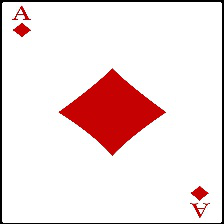

In [100]:
import PIL
img = r'C:\Users\hp\Documents\Datasets\images\cards\test\ace of diamonds\1.jpg'
test_image = PIL.Image.open(img)
test_image

In [101]:
test_image_transformed = transform_norm(test_image)
test_image_transformed.shape

torch.Size([3, 224, 224])

The model expects a batch input, so for a single image, an extra dimension will be added to make it 1 x 3 x 224 x 224. unsqueeze(0) does this easily.

In [103]:
test_unsq = test_image_transformed.unsqueeze(0)
test_unsq.shape

torch.Size([1, 3, 224, 224])

In [104]:
# Running the model on this
test_image_cuda = test_unsq.to(device)
test_out = model(test_image_cuda)
test_out

tensor([[ 1.5974,  6.8542,  6.1656,  2.7855, -3.4461,  5.0440,  4.9771, -0.3989,
         -1.5628,  1.1031,  1.9131, -0.6779, -0.6476,  1.0629,  1.2315,  2.7645,
         -3.6809, -0.9394, -0.3758, -2.7683, -1.7455, -2.6499, -2.7072, -1.2368,
         -3.5970, -4.7970, -0.3880, -1.5873, -5.3950, -1.4947,  1.7982, -0.1118,
         -2.3678, -1.0817,  2.1325,  1.4653, -2.8368,  0.6361,  1.9983, -0.3592,
          0.4286, -3.4912, -0.0190, -3.2304, -3.9021, -1.6014,  3.1998,  2.5802,
         -1.4147, -1.9933,  2.1451,  0.4732, -2.7283]],
       grad_fn=<AddmmBackward0>)

In [105]:
# running it through a SoftMax
test_softmax = torch.nn.functional.softmax(test_out, dim=1)
test_softmax

tensor([[2.6513e-03, 5.0869e-01, 2.5549e-01, 8.6980e-03, 1.7104e-05, 8.3229e-02,
         7.7842e-02, 3.6015e-04, 1.1246e-04, 1.6173e-03, 3.6355e-03, 2.7246e-04,
         2.8084e-04, 1.5535e-03, 1.8387e-03, 8.5176e-03, 1.3524e-05, 2.0976e-04,
         3.6855e-04, 3.3684e-05, 9.3675e-05, 3.7920e-05, 3.5808e-05, 1.5580e-04,
         1.4708e-05, 4.4299e-06, 3.6409e-04, 1.0974e-04, 2.4359e-06, 1.2038e-04,
         3.2409e-03, 4.7989e-04, 5.0277e-05, 1.8194e-04, 4.5274e-03, 2.3232e-03,
         3.1454e-05, 1.0138e-03, 3.9585e-03, 3.7472e-04, 8.2380e-04, 1.6349e-05,
         5.2656e-04, 2.1220e-05, 1.0841e-05, 1.0820e-04, 1.3163e-02, 7.0837e-03,
         1.3041e-04, 7.3120e-05, 4.5845e-03, 8.6139e-04, 3.5062e-05]],
       grad_fn=<SoftmaxBackward0>)

In [106]:
# Convert the prediction tensor to a list, then create a DataFrame with columns named after the dataset classes, ensuring the order matches.
test_df = pd.DataFrame(test_softmax.tolist())
test_df.columns = dataset.classes
test_df

,ace of clubs,ace of diamonds,ace of hearts,ace of spades,eight of clubs,eight of diamonds,eight of hearts,eight of spades,five of clubs,five of diamonds,...,ten of hearts,ten of spades,three of clubs,three of diamonds,three of hearts,three of spades,two of clubs,two of diamonds,two of hearts,two of spades
0,0.002651,0.508695,0.255495,0.008698,0.000017,0.083229,0.077842,0.00036,0.000112,0.001617,...,0.000021,0.000011,0.000108,0.013163,0.007084,0.00013,0.000073,0.004584,0.000861,0.000035


In [107]:
# Wrapping it all in a function
def file_to_conf(path):
    image = PIL.Image.open(path)
    transformed = transform_norm(image)
    unsqueezed = transformed.unsqueeze(0)
    image_cuda = unsqueezed.to(device)

    model.eval()
    with torch.no_grad():
        model_raw = model(image_cuda)
        confidence = torch.nn.functional.softmax(model_raw, dim=1)

    conf_df = pd.DataFrame(confidence.tolist())
    conf_df.columns = dataset.classes
    
    return conf_df

In [108]:
conf_df = file_to_conf(r'C:\Users\hp\Documents\Datasets\images\cards\test\four of clubs\5.jpg')

pred_class = conf_df.iloc[0].idxmax()
conf_score = conf_df.iloc[0].max()

print(f"Predicted class: {pred_class} ({conf_score:.2f})")

Predicted class: four of clubs (0.98)


In [109]:
# Savin the model
import os
os.makedirs("model", exist_ok=True)

torch.save(model.state_dict(), "model/deepnet.pth")

In [110]:
# These cards were downloaded from the internet to test the model
cards = [
    r'C:\Users\hp\Downloads\sevenhearts3.jpg',
    r'C:\Users\hp\Downloads\sevenhearts.jpg',
    r'C:\Users\hp\Downloads\aceclubs.jpg'
    
]

for card in cards:
    conf_df = file_to_conf(card)
    pred_class = conf_df.iloc[0].idxmax()
    conf_score = conf_df.iloc[0].max()
    print(f"Predicted class: {pred_class} ({conf_score:.2f})")

Predicted class: seven of hearts (0.61)
Predicted class: seven of hearts (0.64)
Predicted class: ace of clubs (0.79)
